<a href="https://colab.research.google.com/github/NadaEssamm/Medical_chatbot_DEPI/blob/main/notebooks/Medical_Chatbot_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pip install **

In [ ]:
!pip install spacy nltk datasets transformers torch
!python -m spacy download en_core_web_md
!pip install datasets
!pip install rouge-score
!pip install "datasets[metrics]"
!pip install evaluate
!pip install bert-score
!pip install sentence-transformers # Install sentence-transformers library
!pip install onnx onnxruntime
!pip install textblob
!pip install wordninja
!pip install -U spacy[cuda]


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 18.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-a

# **Libraries**

In [ ]:
from datasets import load_dataset,Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel, AdamW
import torch
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader
from transformers import get_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


import wordninja  # Import the wordninja library
from textblob import TextBlob
from spacy import load


from wordcloud import WordCloud

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from bert_score import score
from sentence_transformers import SentenceTransformer

import time  # Importing the time module

import zipfile
from google.colab import files

# **Load data**

In [ ]:

# Enable streaming mode
streamed_dataset = load_dataset("KaungHtetCho/MedicalQA", split="train", streaming=True)

def chunk_generator(streamed_data, chunksize):
    chunk = []
    for i, example in enumerate(streamed_data):
        chunk.append(example)
        if (i + 1) % chunksize == 0:
            yield chunk  # Return the chunk when size is met
            chunk = []
    if chunk:  # Return the last chunk if there are remaining examples
        yield chunk

# Define chunk size
chunksize = 5000

# Initialize a list to store the first 100 rows
first_100_rows = []
row_limit = 140000  # Limit to 120,000 rows

for chunk in chunk_generator(streamed_dataset, chunksize):
    chunk_dataset = Dataset.from_list(chunk)

    # If we reach the row limit, slice the chunk to get only the needed rows
    if len(first_100_rows) + len(chunk_dataset) > row_limit:
        remaining_rows = row_limit - len(first_100_rows)
        first_100_rows.extend(chunk[:remaining_rows])
        break
    else:
        first_100_rows.extend(chunk)

    if len(first_100_rows) >= row_limit:
        break

# Convert the list of first 100 rows into a Hugging Face dataset
dataset = Dataset.from_list(first_100_rows)
print(f"Final dataset size: {len(dataset)}")

Final dataset size: 140000


# **check null + dublicates**

In [ ]:


# Convert to Pandas DataFrame (dataset is a Hugging Face Dataset object)
train_data = pd.DataFrame(dataset)

# Check for duplicates and null values
initial_size = len(train_data)
train_data = train_data.drop_duplicates()  # Drop duplicate rows
train_data = train_data.dropna()  # Drop rows with any null values

# Size after removing duplicates and null values
after_cleanup_size = len(train_data)
print(f"Original size: {initial_size}")
print(f"Size after removing duplicates and nulls: {after_cleanup_size}")

# Define maximum lengths for context (Patient) and answer (Doctor)
max_len_context = 1000  # Maximum length for context (Patient)
max_len_answer = 500    # Maximum length for answer (Doctor)

# Ensure that 'Patient' and 'Doctor' columns are strings before splitting
train_data['Patient'] = train_data['Patient'].astype(str)
train_data['Doctor'] = train_data['Doctor'].astype(str)

# Filter the dataset based on token length conditions
filtered_data = train_data[
    (train_data['Patient'].str.split().str.len() < max_len_context) &
    (train_data['Doctor'].str.split().str.len() < max_len_answer)
]

# Check the size of the filtered dataset
print(f"Filtered size: {len(filtered_data)}")

# Optionally, convert back to Hugging Face dataset if needed
filtered_dataset = Dataset.from_pandas(filtered_data)


Original size: 140000
Size after removing duplicates and nulls: 137026
Filtered size: 136634


# **Outlier Detection**
+Remove

Number of outliers in Description length: 332
Number of outliers in Patient length: 13577
Number of outliers in Doctor length: 2688


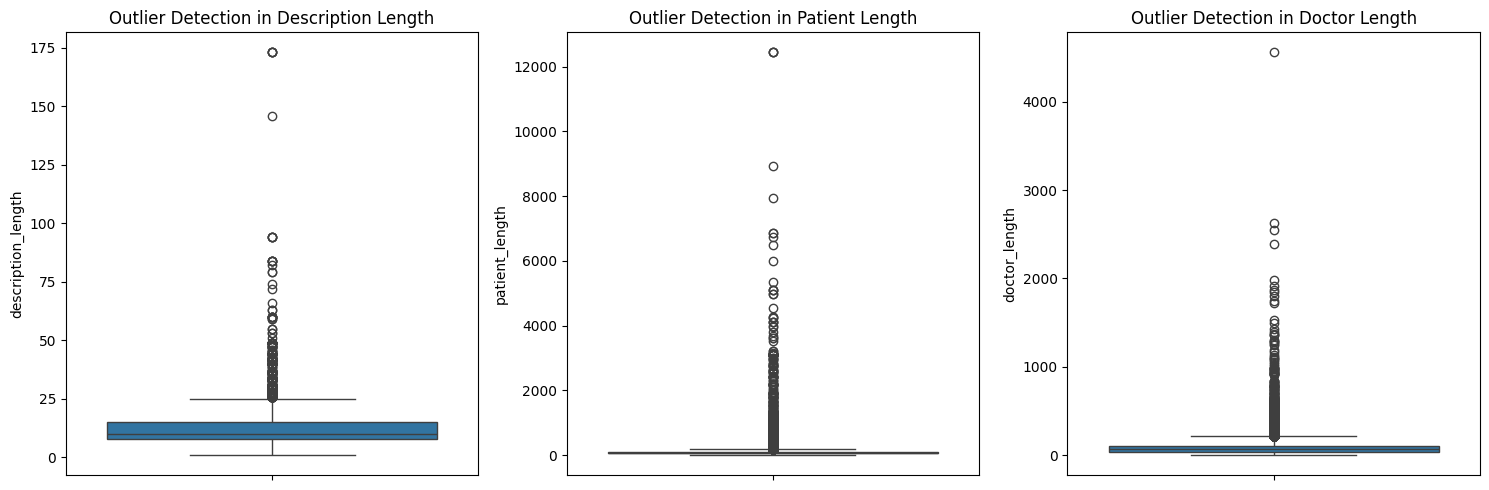

In [ ]:
# Step 1: Define a function for outlier detection
def detect_outliers(data_series, threshold=1.5):
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return data_series[(data_series < lower_bound) | (data_series > upper_bound)]

# Step 2: Detect outliers in text lengths
train_data['description_length'] = train_data['Description'].str.split().str.len()
train_data['patient_length'] = train_data['Patient'].str.split().str.len()
train_data['doctor_length'] = train_data['Doctor'].str.split().str.len()

# Step 3: Identify outliers
description_outliers = detect_outliers(train_data['description_length'])
patient_outliers = detect_outliers(train_data['patient_length'])
doctor_outliers = detect_outliers(train_data['doctor_length'])

# Step 4: Print the number of outliers detected
print(f"Number of outliers in Description length: {len(description_outliers)}")
print(f"Number of outliers in Patient length: {len(patient_outliers)}")
print(f"Number of outliers in Doctor length: {len(doctor_outliers)}")

# Optional: Visualize outliers using box plots
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(y=train_data['description_length'])
plt.title('Outlier Detection in Description Length')

plt.subplot(1, 3, 2)
sns.boxplot(y=train_data['patient_length'])
plt.title('Outlier Detection in Patient Length')

plt.subplot(1, 3, 3)
sns.boxplot(y=train_data['doctor_length'])
plt.title('Outlier Detection in Doctor Length')

plt.tight_layout()
plt.show()


In [ ]:

# Step 5: Remove outliers from the dataset
train_data_filtered = train_data[~train_data['description_length'].isin(description_outliers)]
train_data_filtered = train_data_filtered[~train_data_filtered['patient_length'].isin(patient_outliers)]
train_data_filtered = train_data_filtered[~train_data_filtered['doctor_length'].isin(doctor_outliers)]

# Optional: Check the new size of the filtered dataset
print(f"Size of filtered dataset after removing outliers: {len(train_data_filtered)}")


Size of filtered dataset after removing outliers: 120832


# **Split data**

In [ ]:
from datasets import Dataset

# Split dataset into training and validation sets
train_dataset, val_dataset = train_test_split(train_data_filtered, test_size=0.2, random_state=42)

# Convert back to a Hugging Face dataset
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)

# Check the sizes of the training and validation sets
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Training dataset size: 96665
Validation dataset size: 24167


# **Data analysis**


# **Data Quality Checks**
Check for unexpected values or inconsistencies.

In [ ]:
# Check for overly long entries
max_length_description = train_data['Description'].str.split().str.len().max()
max_length_patient = train_data['Patient'].str.split().str.len().max()
max_length_doctor = train_data['Doctor'].str.split().str.len().max()

print(f"Maximum Length of Description: {max_length_description} words")
print(f"Maximum Length of Patient: {max_length_patient} words")
print(f"Maximum Length of Doctor: {max_length_doctor} words")

# Check for any specific entries that are too short or too long
short_entries = train_data[(train_data['Description'].str.split().str.len() < 3) |
                           (train_data['Patient'].str.split().str.len() < 3) |
                           (train_data['Doctor'].str.split().str.len() < 3)]

print(f"Number of short entries found: {len(short_entries)}")
if len(short_entries) > 0:
    print(short_entries[['Description', 'Patient', 'Doctor']].head())


Maximum Length of Description: 173 words
Maximum Length of Patient: 12442 words
Maximum Length of Doctor: 4558 words
Number of short entries found: 1975
                                           Description  \
105  Please answer with one of the option in the br...   
156  If you are a doctor, please answer the medical...   
188      Please answer the letter of option truthfully   
294  Please answer with one of the option in the br...   
320  Please answer with one of the option in the br...   

                                               Patient  \
105  Q:An 82-year-old male with a history of conges...   
156                                                 Hi   
188  Q:An investigator is studying the incidence of...   
294  Q:A 3-year-old boy is brought to the emergency...   
320  Q:A 29-year-old woman comes to the physician b...   

                                                Doctor  
105                                     C: Hypokalemia  
156  hi thanks for posting your que

# **Text Analysis**
Conduct basic sentiment analysis and visualize word clouds for the most frequent words.

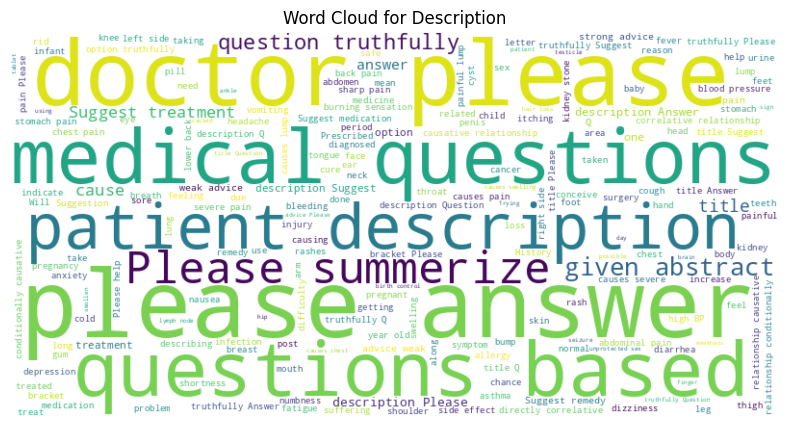

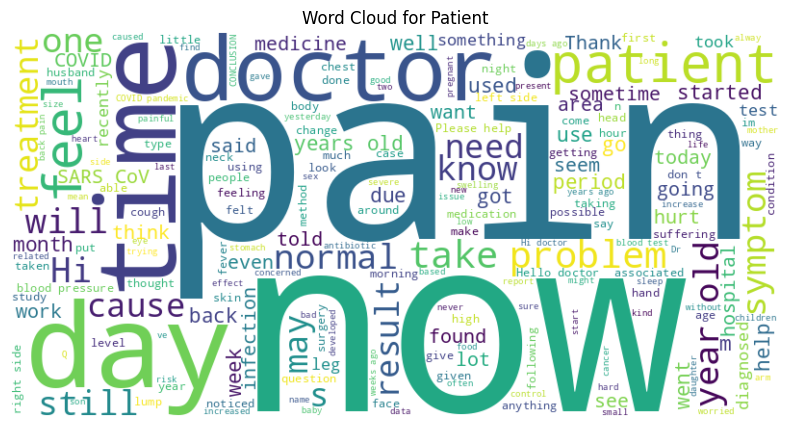

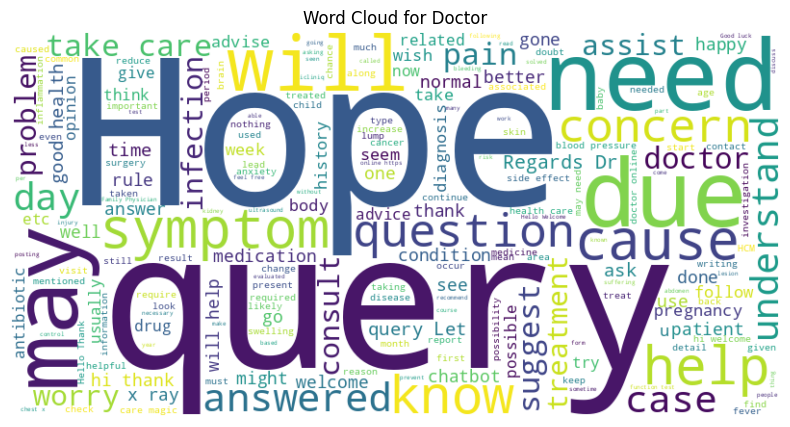

In [ ]:

# Create a word cloud for 'Description'
wordcloud_desc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train_data['Description']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_desc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Description')
plt.show()

# Create a word cloud for 'Patient'
wordcloud_patient = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train_data['Patient']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_patient, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Patient')
plt.show()

# Create a word cloud for 'Doctor'
wordcloud_doctor = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train_data['Doctor']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_doctor, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Doctor')
plt.show()


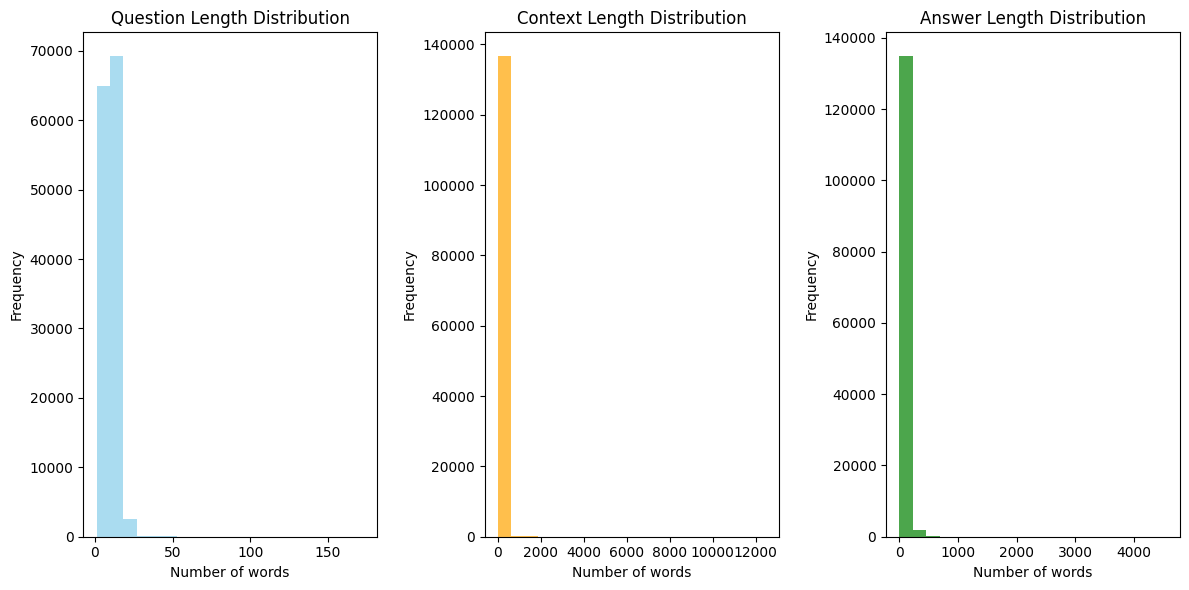

In [ ]:

# Analyze question lengths
question_lengths = [len(q.split()) for q in train_data['Description']]
context_lengths = [len(c.split()) for c in train_data['Patient']]
answer_lengths = [len(a.split()) for a in train_data['Doctor']]

# Plot distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(question_lengths, bins=20, color='skyblue', alpha=0.7)
plt.title('Question Length Distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(context_lengths, bins=20, color='orange', alpha=0.7)
plt.title('Context Length Distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(answer_lengths, bins=20, color='green', alpha=0.7)
plt.title('Answer Length Distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Download NLP

In [ ]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Load SpaCy model
nlp = spacy.load('en_core_web_md')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Load BioBert Model**

In [ ]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Load BioBERT tokenizer and model from Hugging Face
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model = BertModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1').to(device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Define the text columns you want to preprocess
text_columns = ['Description', 'Patient', 'Doctor']

In [ ]:
train_data.head()

,Description,Patient,Doctor,description_length,patient_length,doctor_length
0,"If you are a doctor, please answer the medical...","I am 35 years old unmarried , i was diagonized...",you should get a few other labs checked if thi...,15,77,114
1,What could be the lump in abdominal section?,I have been having abdominal pain and burning ...,Hi...it can be gastroenteritis... take a cours...,8,44,22
2,what are the side effects of thyroxine 100 mg ...,"sir, Day before yesterday i had an oil fried i...","Hi, You suffer from some colon infection due ...",13,152,70
3,"If you are a doctor, please answer the medical...","friend has a lump where their coccyx is, has b...","hello and welcome to chatbot, a painful lump o...",15,56,102
4,Answer this question truthfully,Which demographic should raise suspicion of a ...,The demographic that should alert you to possi...,4,10,27


# **Preprocissing**

In [ ]:

spacy.prefer_gpu()  # Ensure that SpaCy prefers GPU

# Preprocessing function using SpaCy and NLTK with spell checking
def preprocess_text(text):
    # Lowercasing the text
    text = text.lower()

    # Use wordninja to split concatenated words
    text = ' '.join(wordninja.split(text))  # Split concatenated words using wordninja

    # Remove special characters
    text = re.sub("^\s+", "", text)       # Remove space from the start of the sentence
    text = re.sub("\s+$", "", text)       # Remove space from the end of the sentence
    text = re.sub("(\?|!)+", " ", text)   # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)   # Remove special characters

    # Spell check using TextBlob
    text = str(TextBlob(text).correct())  # Correct spelling

    # Tokenization using NLTK
    words = nltk.word_tokenize(text)

    # Remove "hi" and "hello" and stopwords
    words = [word for word in words if word not in stop_words and word not in ['hi', 'hello']]

    # Lemmatization using SpaCy
    doc = nlp(" ".join(words))  # Processing with SpaCy
    lemmatized_words = [token.lemma_ for token in doc]

    return " ".join(lemmatized_words)



In [ ]:
# Apply preprocessing to multiple columns
def preprocess_multiple_columns(dataset, text_columns):
    for column in text_columns:
        dataset = dataset.map(lambda example: {f'preprocessed_{column}': preprocess_text(example[column])})
    return dataset

In [ ]:
## Preprocess the dataset columns
#preprocessed_dataset = preprocess_multiple_columns(dataset, text_columns)
# Preprocess the dataset columns
train_dataset = preprocess_multiple_columns(train_dataset, text_columns)
val_dataset = preprocess_multiple_columns(val_dataset, text_columns)

Map:   0%|          | 0/96665 [00:00<?, ? examples/s]

Map:   0%|          | 0/96665 [00:00<?, ? examples/s]

In [ ]:


# Step 1: Save datasets as CSV files
train_csv_path = 'train_dataset.csv'
val_csv_path = 'val_dataset.csv'

train_dataset.to_csv(train_csv_path, index=False)
val_dataset.to_csv(val_csv_path, index=False)

# Step 2: Create a ZIP file containing both CSV files
zip_file_path = 'Preprocessed_datasets.zip'
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    zipf.write(train_csv_path)
    zipf.write(val_csv_path)

# Step 3: Download the ZIP file
files.download(zip_file_path)


# **Embadding**

In [ ]:
# # Generate BioBERT embeddings for the preprocessed text
# def generate_embeddings(text):
#     inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     # Average pooling the last hidden state to get a single vector representation
#     embeddings = outputs.last_hidden_state.mean(dim=1)
#     return embeddings.cpu().numpy()  # Move back to CPU for numpy conversion
from torch.utils.data import DataLoader

def generate_embeddings(batch_texts):
    # Tokenize and generate embeddings for a batch of texts
    inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Average pooling to get a single vector representation for each text
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()


In [ ]:
# # Apply BioBERT embeddings to the preprocessed text columns
# def apply_biobert_embeddings(dataset, text_columns):
#     for column in text_columns:
#         dataset = dataset.map(lambda example: {f'embeddings_{column}': generate_embeddings(example[f'preprocessed_{column}'])})
#     return dataset

# # Generate embeddings for preprocessed columns
# #embedded_dataset = apply_biobert_embeddings(preprocessed_dataset, [col for col in text_columns])

# # Generate embeddings for preprocessed columns
# train_dataset = apply_biobert_embeddings(train_dataset, text_columns)
# val_dataset = apply_biobert_embeddings(val_dataset, text_columns)


def apply_biobert_embeddings(dataset, text_columns, batch_size=64):
    for column in text_columns:
        all_embeddings = []
        # Create a DataLoader to process the preprocessed text in batches
        dataloader = DataLoader(dataset[f'preprocessed_{column}'], batch_size=batch_size, shuffle=False)
        for batch in dataloader:
            # Convert the batch to a list of texts
            batch_texts = list(batch)
            # Generate embeddings for the batch
            embeddings = generate_embeddings(batch_texts)
            all_embeddings.extend(embeddings)  # Collect embeddings for all batches
        # Add the embeddings as a new column to the dataset
        dataset = dataset.add_column(f'embeddings_{column}', all_embeddings)
    return dataset

# Apply BioBERT embeddings to the training and validation datasets with batch processing
train_dataset = apply_biobert_embeddings(train_dataset, text_columns, batch_size=64)
val_dataset = apply_biobert_embeddings(val_dataset, text_columns, batch_size=64)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [ ]:
# Step 1: Save datasets as CSV files
emb_train_csv_path = 'train_dataset.csv'
emb_val_csv_path = 'val_dataset.csv'

train_dataset.to_csv(emb_train_csv_path, index=False)
val_dataset.to_csv(emb_val_csv_path, index=False)

# Step 2: Create a ZIP file containing both CSV files
zip_file_path = 'embaded_datasets.zip'
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    zipf.write(emb_train_csv_path)
    zipf.write(emb_val_csv_path)

# Step 3: Download the ZIP file
files.download(zip_file_path)


Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

916542

# **Cosine similarity**

In [ ]:
# Function to find the most similar answer for a given question using cosine similarity
#Newwwwwwwwwwwwwwwwwwwwwwwwwww one
def find_most_similar(question, dataset, column_name):
    question_embedding = generate_embeddings(question)
    answer_embeddings = np.vstack(dataset[column_name])

    # Calculate cosine similarity
    similarities = cosine_similarity(question_embedding, answer_embeddings)

    # Get the index of the most similar answer
    best_match_idx = int(np.argmax(similarities))  # Ensure this is a Python int

    # Check if the similarity is above a certain threshold to consider it a valid match
    threshold = 0.5  # Adjust this threshold as necessary
    if similarities[0][best_match_idx] < threshold:
        return {"Description": "I'm sorry, I couldn't find a relevant answer."}


    # Return the most similar answer/document
    return {column: dataset[best_match_idx][column] for column in dataset.features.keys() if column.startswith('preprocessed_') or column.startswith('embeddings_')}








In [ ]:
# Example chatbot: Ask a medical question and get the best-matching answer
user_question = "What could be the lump in abdominal section??"

# Find the most relevant answer
best_match = find_most_similar(user_question, train_dataset, 'embeddings_Description')


In [ ]:
print(" the best match"  , best_match['preprocessed_Doctor'])  # Modify column name as needed
##expected answer
#SThe demographic that should alert you to possible Rubella infection includes patients who have not been vaccinated, such as immigrants or those who are against vaccinations (anti-vaxxers).
#

 the best match hiit gastroenteritis take course antibiotic preprobiotic along omez finedr ashish verma


# **Mini Chtbot**

In [ ]:


def get_medical_answer(question):
    best_match = find_most_similar(question, train_dataset, 'embeddings_Description')
    return best_match['preprocessed_Doctor']  # Return the preprocessed doctor response

# Example usage
user_question = "What causes mild pain in the right kidney area and stiffness in neck?"
answer = get_medical_answer(user_question)
print("Best match answer:", answer)

Best match answer: helloyou do not need get worriedcyst occur many healthy peoplejust make sure every year u atleast get renal function test do


In [ ]:
while True:
    user_question = input("Ask a medical question (or type 'exit' to quit): ")
    if user_question.lower() == 'exit':
        break
    answer = get_medical_answer(user_question)
    print("Best match answer:", answer)

Ask a medical question (or type 'exit' to quit): What causes mild pain in the right kidney area and stiffness in neck?
Best match answer: helloyou do not need get worriedcyst occur many healthy peoplejust make sure every year u atleast get renal function test do
Ask a medical question (or type 'exit' to quit): exit


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming generate_embeddings is defined elsewhere and works as expected
# Function to find top matches
def find_top_matches(question, dataset, column_name, top_n=1):
    # Generate embeddings for the user question
    question_embedding = generate_embeddings(question).reshape(1, -1)

    # Stack the embeddings from the dataset column
    answer_embeddings = np.vstack(dataset[column_name])

    # Calculate cosine similarities between the question embedding and all answer embeddings
    similarities = cosine_similarity(question_embedding, answer_embeddings)

    # Get the indices of the top N most similar answers
    best_match_indices = similarities.argsort()[0][-top_n:][::-1]  # Get top N indices

    # Extract the relevant information for the top matches
    top_matches = []
    for idx in best_match_indices:
        idx = int(idx)  # Ensure idx is a regular Python integer, not a NumPy integer
        match = {
            'Description': dataset[idx]['preprocessed_Description'],
            'Patient': dataset[idx]['preprocessed_Patient'],
            'Doctor': dataset[idx]['preprocessed_Doctor'],
            'Embedding_Description': dataset[idx]['embeddings_Description'],
            'Embedding_Patient': dataset[idx]['embeddings_Patient'],
            'Embedding_Doctor': dataset[idx]['embeddings_Doctor']
        }
        top_matches.append(match)

    return top_matches

# Example usage
user_question = "What could be the lump in abdominal section?"
top_matches = find_top_matches(user_question, train_dataset, 'embeddings_Description', top_n=1)

# Print the matches
for i, match in enumerate(top_matches):
    print(f"Match {i + 1}: {match['Doctor']}")


Match 1: hiit gastroenteritis take course antibiotic preprobiotic along omez finedr ashish verma


# **model train**

In [ ]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments

# Set environment variable for CUDA memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Load a pre-trained language model and tokenizer
model_name = "gpt2"  # You can choose a larger model if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Assign a pad token
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name)
model.cuda()  # Move the model to GPU

# Preprocessing function
def preprocess_function(examples):
    return {"text": examples["Description"] + " " + examples["Patient"] + " " + examples["Doctor"]}

# Tokenization function with attention mask
def tokenize_function(examples):
    tokenized = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
    tokenized["labels"] = tokenized["input_ids"].copy()  # Set labels to input_ids for loss computation
    return tokenized

# Tokenize the dataset
dataset = dataset.map(preprocess_function)  # Make sure to uncomment and load your dataset here
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Prepare for training
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Updated parameter name
    per_device_train_batch_size=4,  # Reduced batch size
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    gradient_accumulation_steps=2,   # Gradient accumulation
    fp16=True,                        # Mixed precision
)

# Trainer class to handle training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,
)

# Start training the model
trainer.train()

# Save the model after training
trainer.save_model("./medical_chatbot_model")


print("model traind")


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
0,5.799700,1.819389
2,1.772700,1.639696


model traind


In [ ]:
# Save the trained model and tokenizer
output_dir = "./medical_chatbot_model"

trainer.save_model(output_dir)  # This saves the model
tokenizer.save_pretrained(output_dir)  # This saves the tokenizer


In [ ]:
import shutil

# Create a zip file of the saved model directory
shutil.make_archive("medical_chatbot_model", 'zip',output_dir)

# Download the zip file
from google.colab import files
files.download("medical_chatbot_model.zip")


# **Evaluation**

In [ ]:
# Evaluate the model on the validation dataset
evaluation_results = trainer.evaluate()

# Display the evaluation results
print("Evaluation results:", evaluation_results)


Evaluation results: {'eval_loss': 1.6396957635879517, 'eval_runtime': 2.598, 'eval_samples_per_second': 38.49, 'eval_steps_per_second': 9.623, 'epoch': 2.88}


In [ ]:


# Function to preprocess test data
def preprocess_test_data(test_dataset):
    true_responses = [str(answer) for answer in test_dataset['Doctor']]
    patient_queries = [str(question) for question in test_dataset['Patient']]
    return true_responses, patient_queries

# Function to generate responses from the model
def generate_responses(patient_queries):
    generated_responses = []
    model.eval()
    model.to('cpu')

    with torch.no_grad():
        for query in patient_queries:
            inputs = tokenizer(query, return_tensors='pt', padding=True, truncation=True, max_length=512)
            for key in inputs.keys():
                inputs[key] = inputs[key].to('cpu')

            outputs = model.generate(**inputs, max_length=512, num_return_sequences=1)
            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            generated_responses.append(generated_text)

    return generated_responses

# Function to calculate BLEU Score
def calculate_bleu(reference, hypothesis):
    reference_tokens = [nltk.word_tokenize(reference.lower())]
    hypothesis_tokens = nltk.word_tokenize(hypothesis.lower())
    return sentence_bleu(reference_tokens, hypothesis_tokens)

# Function to calculate ROUGE Score
def calculate_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return scores['rouge1'].fmeasure, scores['rougeL'].fmeasure

# Load a pre-trained model for BERTScore and cosine similarity
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

# Function to calculate cosine similarity between embeddings
def calculate_cosine_similarity(true_responses, generated_responses):
    true_embeddings = embedder.encode(true_responses, convert_to_tensor=True)
    generated_embeddings = embedder.encode(generated_responses, convert_to_tensor=True)
    cosine_sim = cosine_similarity(true_embeddings.cpu(), generated_embeddings.cpu())
    avg_cosine_similarity = cosine_sim.diagonal().mean()
    return avg_cosine_similarity

# Function to evaluate using BLEU, ROUGE, BERTScore, and cosine similarity
def evaluate_all_metrics(true_responses, generated_responses):
    bleu_scores = []
    rouge1_scores = []
    rougeL_scores = []

    # Calculate BLEU and ROUGE for each response
    for true_response, generated_response in zip(true_responses, generated_responses):
        bleu_score = calculate_bleu(true_response, generated_response)
        rouge1_score, rougeL_score = calculate_rouge(true_response, generated_response)

        bleu_scores.append(bleu_score)
        rouge1_scores.append(rouge1_score)
        rougeL_scores.append(rougeL_score)

    # Calculate average BLEU and ROUGE scores
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

    # Calculate BERTScore
    P, R, F1 = score(generated_responses, true_responses, lang="en", model_type="bert-base-uncased")
    avg_bertscore_f1 = F1.mean().item()

    # Calculate cosine similarity
    avg_cosine_similarity = calculate_cosine_similarity(true_responses, generated_responses)

    # Print all evaluation metrics
    print("Evaluation Metrics:")
    print(f"Average BLEU Score: {avg_bleu * 100:.2f}%")
    print(f"Average ROUGE-1 F1 Score: {avg_rouge1 * 100:.2f}%")
    print(f"Average ROUGE-L F1 Score: {avg_rougeL * 100:.2f}%")
    print(f"Average BERTScore F1 Score: {avg_bertscore_f1 * 100:.2f}%")
    print(f"Average Cosine Similarity: {avg_cosine_similarity * 100:.2f}%")

# Load the test dataset
df = pd.read_csv('/content/test_dataset.csv')

# For 100 rows, use only 20 rows from test data
test_dataset = df.head(20)

# For 120k rows, load 50k of test data
# test_dataset = df.head(50000)

# Split the data into true and patient queries
true_responses, patient_queries = preprocess_test_data(test_dataset)

# Generate responses using the model
generated_responses = generate_responses(patient_queries)

# Evaluate the model
evaluate_all_metrics(true_responses, generated_responses)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generat

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Evaluation Metrics:
Average BLEU Score: 6.54%
Average ROUGE-1 F1 Score: 22.55%
Average ROUGE-L F1 Score: 15.86%
Average BERTScore F1 Score: 50.00%
Average Cosine Similarity: 67.18%


# **Mini prompt**

In [ ]:
# (Optional) Test the model by generating a response
prompt = "As a healthcare professional, please describe the common symptoms of diabetes in detail."
#prompt = "What are the common symptoms of diabetes that patients should be aware of?"

inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to('cuda')  # Move inputs to GPU

# Ensure the model is on the same device (cuda)
model.to('cuda')

output = model.generate(
    inputs["input_ids"],
    max_length=200,  # Increased length for more content
    attention_mask=inputs["attention_mask"],
    num_return_sequences=1,
    temperature=1.5,  # Increased randomness
    top_k=70,
    top_p=0.95
)

response = tokenizer.decode(output[0], skip_special_tokens=True)
print("Response:", response)


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:589: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `70` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Response: As a healthcare professional, please describe the common symptoms of diabetes in detail.


In [ ]:
import torch
from transformers import AutoModelForCausalLM

# Load your trained model
model = AutoModelForCausalLM.from_pretrained("./medical_chatbot_model")

# Set the model to evaluation mode
model.eval()

# Define dummy input for the model (use the same shape as your input data)
dummy_input = torch.randint(0, tokenizer.vocab_size, (1, 512))  # Adjust shape as needed

# Export the model to ONNX format
torch.onnx.export(model,
                  dummy_input,
                  "medical_chatbot_model.onnx",
                  input_names=['input_ids'],
                  output_names=['output'],
                  dynamic_axes={'input_ids': {0: 'batch_size', 1: 'sequence_length'}, 'output': {0: 'batch_size'}})


In [ ]:
from google.colab import files
files.download("medical_chatbot_model.onnx")
